# Summary of Steps taken and performance achieved

Multiple models with different levels of complexity were attempted. The dependent and independent variables seem to have a nonlinear relationship as the performance of models improved with increasing complexity. MAPE was selected as the evaluation metric.Regularization, feature selection and hyper-parameter tuning was employed to improve the model performance. The models attempted are

1. Linear Regression with no regularization
2. Ridge and Lasso
3. Gradient Boosting
4. Random Forest
5. XGboost
6. Support Vector Machine
7. Stacking - ensemble of the best estimators of the above tuned models with a meta regressor (i.e. Ridge) which gave the best result (MAPE of less than 10)

https://github.com/Pranov1984/Prediction-of-cement-compressive-strength-using-stacked-ensemble-modelling/blob/master/Concrete%20Compressive%20Strength%20Prediction-V3.ipynb

# Data

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge,LassoCV, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from matplotlib.pylab import rcParams

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/MSML/Concrete/DATASET/concrete.csv")

In [5]:
df.columns = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age', 'strength']

In [6]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

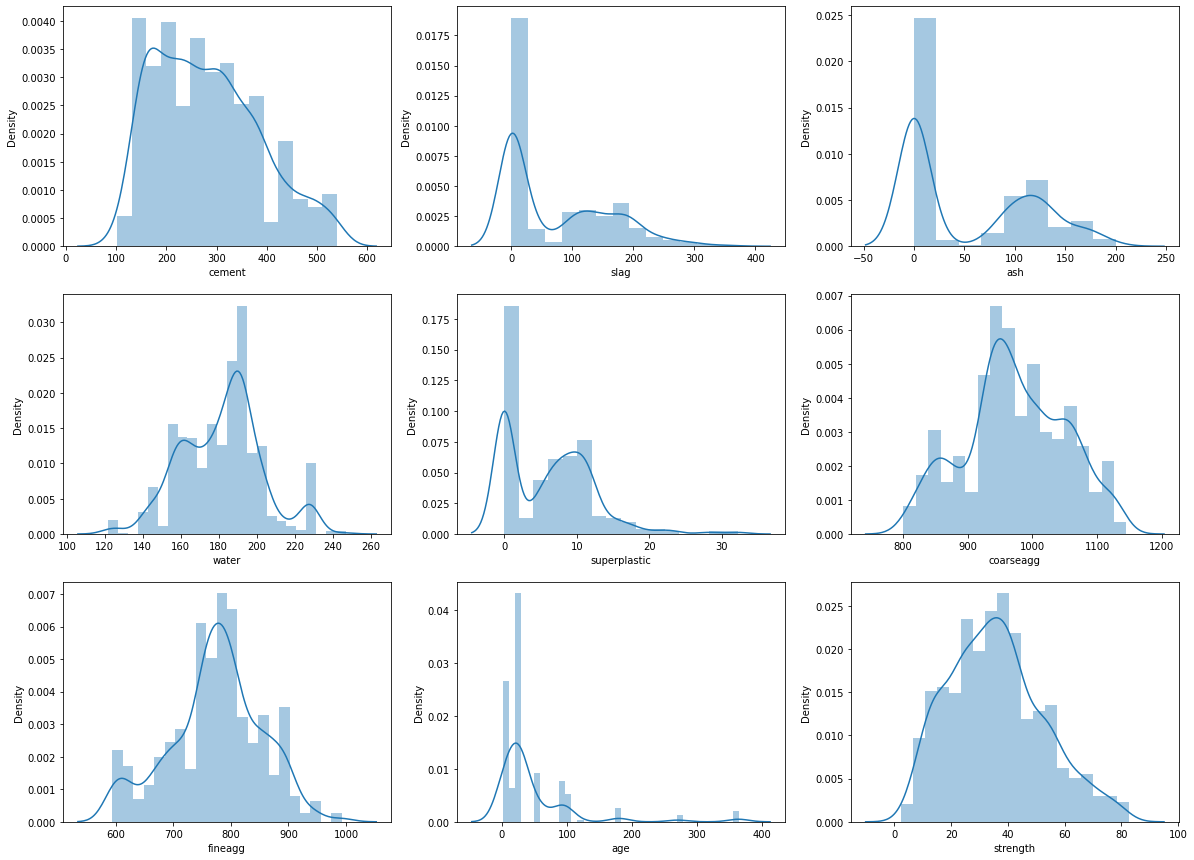

In [7]:
var=np.arange(1,len(df.columns)+1)
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.distplot(df.iloc[:,(i-1)])

## Outliers

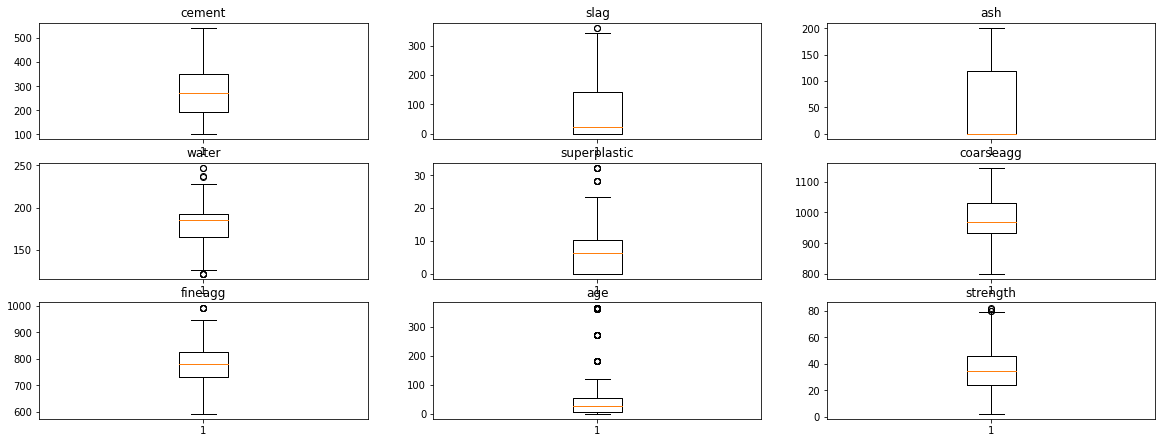

In [8]:
figsize(20, 15)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [9]:
Q1=np.percentile(df['slag'],25)
Q3=np.percentile(df['slag'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.slag=np.where(df.slag>UL, UL, df.slag)

In [10]:
Q1=np.percentile(df['fineagg'],25)
Q3=np.percentile(df['fineagg'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.fineagg=np.where(df.fineagg>UL, UL, df.fineagg)

In [11]:
Q1=np.percentile(df['water'],25)
Q3=np.percentile(df['water'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.water=np.where(df.water>UL, UL, df.water)

In [ ]:
Q1=np.percentile(df['age'],25)
Q3=np.percentile(df['age'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.age=np.where(df.age>UL, UL, df.age)

In [12]:
Q1=np.percentile(df['superplastic'],25)
Q3=np.percentile(df['superplastic'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.superplastic=np.where(df.superplastic>UL, UL, df.superplastic)

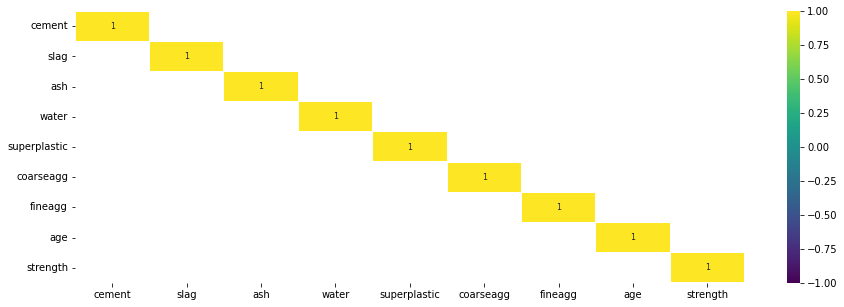

In [13]:
corr=df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.70) | (corr <= -0.70)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

no major correlations amongst the variables and hence no multicollinearity expected to affect the performance of models

## Clustering, 샘플을 n개로 군집화

#### Elbow Method

Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 군집의 개수로 사용. inertia_속성으로 확인 할 수 있다.

In [14]:
from sklearn.cluster import KMeans

In [15]:
cl=np.arange(1,9)  # k_range
ess=[]   # ineretia_
for i in cl:
    clust=KMeans(n_init=15,n_clusters=i)
    clust.fit(df.iloc[:,0:8])
    error=clust.inertia_
    ess.append(error)

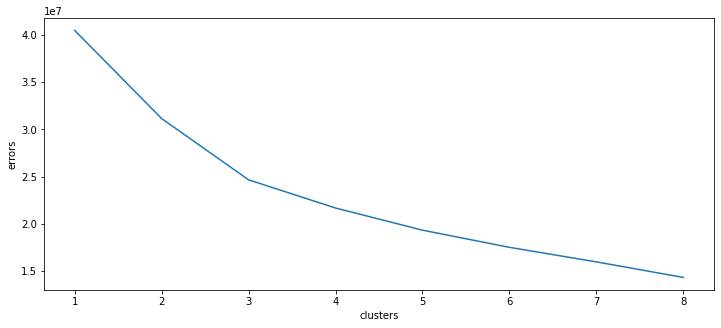

In [16]:
a=pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(a.clusters, a.errors)

elbow seen at 3 clusters

In [17]:
clust=KMeans(n_init=15, n_clusters=3)
clust.fit(df.iloc[:,0:8])
df['cluster']=clust.predict(df.iloc[:,0:8])
df.cluster=pd.Categorical(df.cluster)

In [18]:
df.cluster.value_counts() , df.columns

(0    350
 1    345
 2    335
 Name: cluster, dtype: int64,
 Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
        'fineagg', 'age', 'strength', 'cluster'],
       dtype='object'))

In [19]:
X=df.iloc[:,[0,1,2,3,4,5,6,7,9]].values
y=df.strength.values

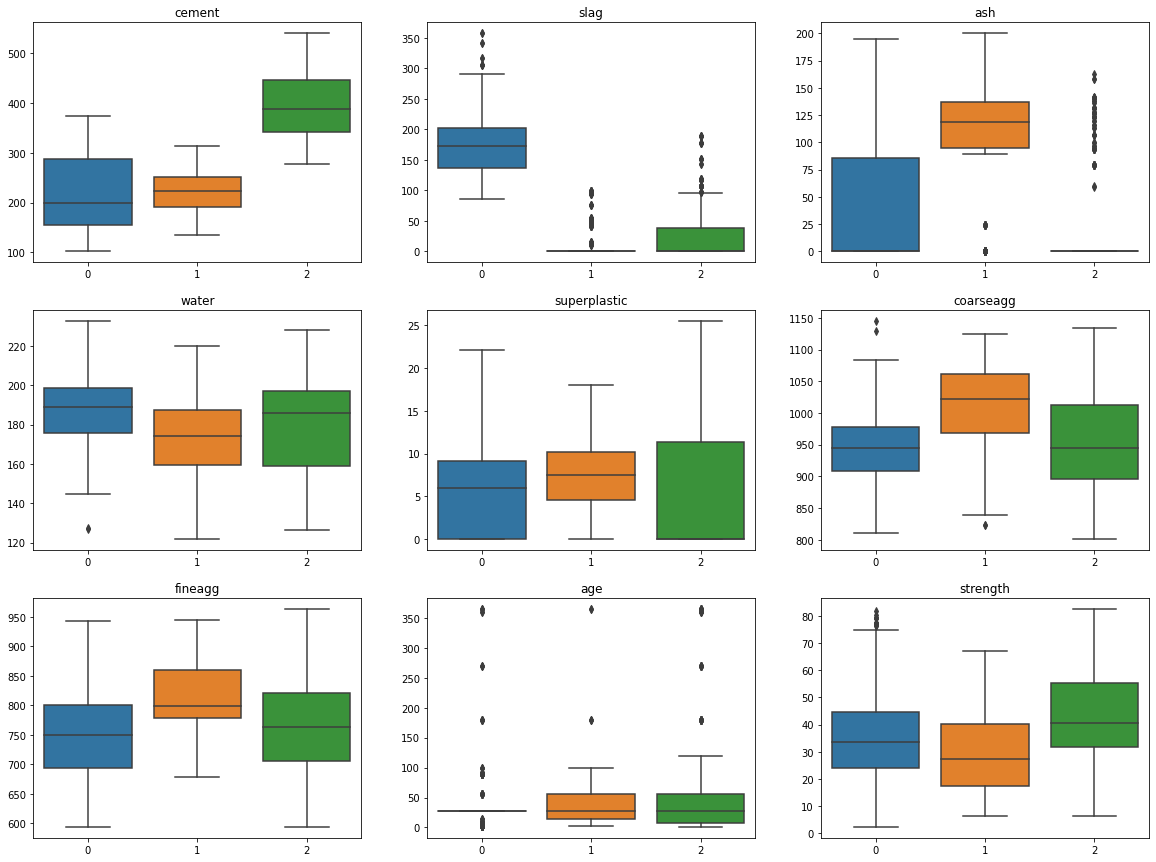

In [20]:
var=np.arange(1,len(df.columns))
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.boxplot(df.iloc[:,9],df.iloc[:,(i-1)])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(df.columns[i-1])

**There seems to be three distinct clusters, especially when we see the distribution for strength of cement.**

---




There are a few more outliers when the distribution seen for each cluster which we may or may not want to treat depending on our model performances.

#### We check below the performance of models with addition of the new variable i.e. cluster

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def test(models, X,y, iterations = 100):  # train/test set으로 나누고, model로 훈련시킨 후, 예측, 점수 계산하는 메소드
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=1)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [23]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.644215,0.635669,0.644214
1,0.537844,0.523485,0.537798


Hyperparameter Tuning / Regularization introduced

In [24]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS':LinearRegression(),
           'Lasso': GridSearchCV(Lasso(),param_grid=lasso_params, cv=10).fit(X,y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv=10).fit(X, y).best_estimator_,}

test(models2, X,y)

,OLS,Lasso,Ridge
0,0.644215,0.644206,0.641183
1,0.537844,0.537680,0.530253


#### Try the models without the new variable

In [25]:
X=df.iloc[:,0:8].values
y=df.strength.values

models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.635917,0.635669,0.635917
1,0.520277,0.523485,0.520279


No major difference observed with regularization. Also the addition of cluster did not improve the results.

## So proceeding without the new column

In [64]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

In [65]:
k=len(df.columns)-1
n_valid=len(X_valid)
n_test=len(X_test)

#### Ridge

In [28]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train,y_train)
Rid_gs.best_estimator_

Ridge(alpha=10)

In [29]:
print(Rid_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Rid_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Rid_gs.predict(X_test))


Rsq_Adj_valid_RidGS= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_RidGS:%.2f'%Rsq_Adj_valid_RidGS)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_RidGS= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_RidGS:%.2f'%Rsq_Adj_test_RidGS)


MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-113.5427865409195
Rsq:0.63
Correlation_Validation: 0.7912513912854623
Correlation_Test: 0.7408227778700601
Rsq_Adj_valid_RidGS:0.38
Rsq_Adj_test_RidGS:0.24
MAPE_RidGS:29.32


In [30]:
Rid_gs.best_estimator_.coef_

array([ 0.11815561,  0.10406123,  0.10033617, -0.21127017,  0.22872808,
        0.00734018,  0.00752245,  0.1114996 ])

#### Lasso

In [66]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train,y_train)
Las_gs.best_estimator_

Lasso(alpha=5)

In [67]:
print(Las_gs.best_score_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test))[0,1]

Rsq_valid=r2_score(y_valid,Las_gs.predict(X_valid))
Rsq_test=r2_score(y_test,Las_gs.predict(X_test))


Rsq_Adj_valid_Lasso= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid_Lasso:%.2f'%Rsq_Adj_valid_Lasso)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test_Lasso= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_Lasso:%.2f'%Rsq_Adj_test_Lasso)


MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

-111.84526590473823
Rsq:0.62
Correlation_Validation: 0.7863827865142023
Correlation_Test: 0.7394794485665521
Rsq_Adj_valid_Lasso:0.37
Rsq_Adj_test_Lasso:0.25
MAPE_Lasso:29.41


In [68]:
Las_gs.best_estimator_.coef_

array([ 0.11656387,  0.1019875 ,  0.10308083, -0.24974905,  0.        ,
       -0.        ,  0.00305857,  0.10945128])

No difference in performance of Ridge or Lasso models.

## Attempt to fit models by transforming the input variables to higher dimension

Try with polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2)

X_train_tr=poly.fit_transform(X_train)
X_valid_tr=poly.fit_transform(X_valid)
X_test_tr=poly.fit_transform(X_test)

#### Ridge

In [ ]:
param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train_tr,y_train)
Rid_gs.best_estimator_

print(Rid_gs.best_score_ , Rid_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Rid_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1])
RidGS_corr_valid=np.corrcoef(y_valid,Rid_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1])
RidGS_corr_test=np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1]

MAPE_RidGS=mean_absolute_percentage_error(y_test,Rid_gs.predict(X_test_tr))
print('MAPE_RidGS:%.2f' %MAPE_RidGS)

-51.6334547924388 Ridge(alpha=0.1)
Rsq:0.85
Correlation_Validation: 0.921341565835012
Correlation_Test: 0.8943231286981875
MAPE_RidGS:16.96


Improved performance with polynomial features of degree 2 which means the relationship between X and Y is non-linear and hence complex models may do better than simpler models.

Ridge with Polynomial features so far has given the best results with least MAPE and highest adjusted Rsq

#### Lasso

In [61]:
param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train_tr,y_train)

print(Las_gs.best_score_ , Las_gs.best_estimator_)
print("Rsq:%.2f" %r2_score(y_valid,Las_gs.predict(X_valid_tr)))
print("Correlation_Validation:", np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1])
Lasso_corr_valid=np.corrcoef(y_valid,Las_gs.predict(X_valid_tr))[0,1]
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1])
Lasso_corr_test=np.corrcoef(y_test,Las_gs.predict(X_test_tr))[0,1]

MAPE_Lasso=mean_absolute_percentage_error(y_test,Las_gs.predict(X_test_tr))
print('MAPE_Lasso:%.2f' %MAPE_Lasso)

NameError: ignored

Almost identical results for both Ridge and Lasso is achieved.

Since the relationship between dependent and independent variables is non-linear, we could try to fit complex models to better capture the relationship. As the complexity of the models increases, the bias decreases but variance increases. However, in the initial stages, the rate of decrease in error due to bias is more than the rate of increase in variance error.

Hence we need to find the right complexity which will give optimal results i.e. the lowest test error. Beyond the optimal point, the rate in increase in error due to variance overtakes the decrease in bias error and hence the total error goes up.

# Ensemble, Try Tree based models with varying complexity to get the best estimator. 

**SVM** could also be tried. Also **PCA along with clustering** could be tried before **Lasso** and **Ridge** to see if there is improvement in performance

## Boosting

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor()

In [35]:
predictors=df.drop(['strength','cluster'], axis=1).columns
predictors

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

In [36]:
def modelfit(alg, dtrain,dvalid,dtest,performCV=True, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    
    #Predict valid set:
    dvalid_predictions = alg.predict(X_valid)    
    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Validation): %.4g" % r2_score(y_valid, dvalid_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("\n")
    print("MAPE (Train): %f" %mean_absolute_percentage_error(y_train, dtrain_predictions))
    print("MAPE (Valid): %f" %mean_absolute_percentage_error(y_valid, dvalid_predictions))
    print("MAPE (Test): %f" %mean_absolute_percentage_error(y_test, dtest_predictions))
    print('\n')
    print("Correlation Coeff (Test): %f" %np.corrcoef(y_test,dtest_predictions)[0,1])
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### Choose all predictors


Model Report
Rsq (Train): 0.9688
Rsq (Validation): 0.8905
Rsq (Test): 0.8637


MAPE (Train): 8.227362
MAPE (Valid): 14.832265
MAPE (Test): 13.260318


Correlation Coeff (Test): 0.929868
CV Score : Mean - -34.21873 | Std - 11.08228 | Min - -52.24625 | Max - -18.64129


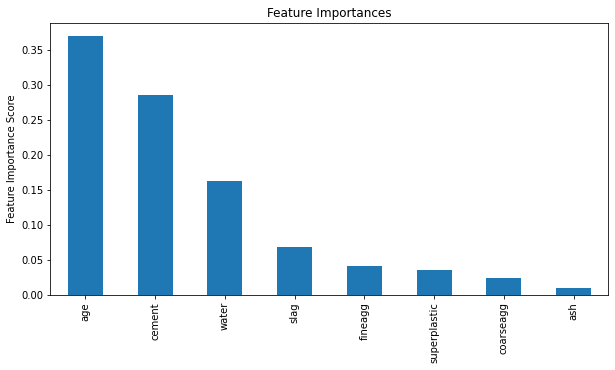

In [ ]:
plt.figure(figsize=(10,5))
modelfit(gbr, X_train, X_valid, X_test)

### Parameter Tuning.

####  Start with number of trees (n_estimators)

앙상블의 하이퍼파라미터
*   n_estimators(트리 수), 훈련을 제어하는 변수
*   max_depth, 성장을 제어하는 변수
*   min_samples_split
*   max_features


Drop variables that are not significant as can be seen above (ash and coarseagg)

In [ ]:
X=df.drop(['ash','coarseagg','strength','cluster'], axis=1).values
y=df.strength.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['ash','coarseagg','strength', 'cluster'], axis=1).columns

In [ ]:
param_test1 = {'n_estimators':range(20,150,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=15,min_samples_leaf=15,
                                                               max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 140}, -28.9359879035073)

N_estimators is best at 140.

#### Fix **n_estimator** and tune for **max_depth** along with **min_samples_split**

In [ ]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=140,
                                                               max_features='sqrt',subsample=0.8,random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_

({'max_depth': 11, 'min_samples_split': 10}, -28.494823450583347)

replace maxdepth = 11, n min_samples_split=10. Check the performance.


Model Report
Rsq (Train): 0.9811
Rsq (Validation): 0.8986
Rsq (Test): 0.8893


MAPE (Train): 5.868836
MAPE (Valid): 13.771682
MAPE (Test): 11.621894


Correlation Coeff (Test): 0.943037
CV Score : Mean - -28.49482 | Std - 10.30385 | Min - -42.90822 | Max - -15.85265


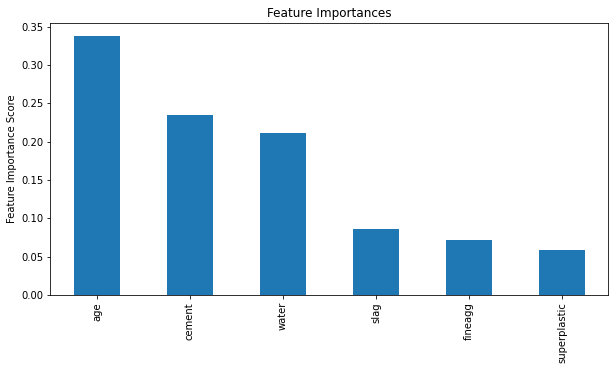

In [ ]:
plt.figure(figsize=(10,5))
modelfit(gs2.best_estimator_,X_train, X_valid, X_test)

Text(0.5, 1.0, 'Actuals v Predicted')

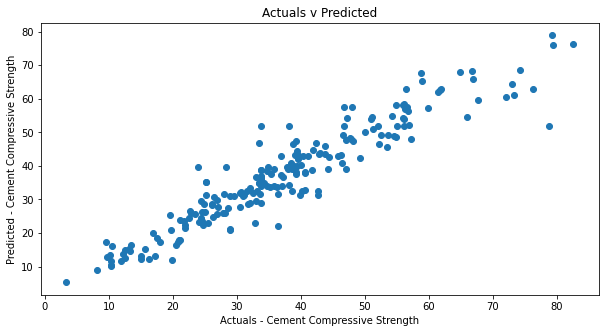

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs2.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

#### Now lets tune the last tree-parameters, i.e. **max_features** by trying values from 3 to 7 in steps of 1.

In [ ]:
param_test3 = {'max_features':range(3,7,1)}

gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=140,
                                                               max_depth=11,subsample=0.8,random_state=10,
                                                              min_samples_split=10),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs3=gsearch3.fit(X_train,y_train)
gs3.best_params_, gs3.best_score_

({'max_features': 3}, -27.846808343132796)

replace max_features = 3 and Check the performance


Model Report
Rsq (Train): 0.981
Rsq (Validation): 0.8973
Rsq (Test): 0.8925


MAPE (Train): 5.895516
MAPE (Valid): 13.335663
MAPE (Test): 11.058310


Correlation Coeff (Test): 0.945122
CV Score : Mean - -27.84681 | Std - 9.040212 | Min - -44.68582 | Max - -15.40852


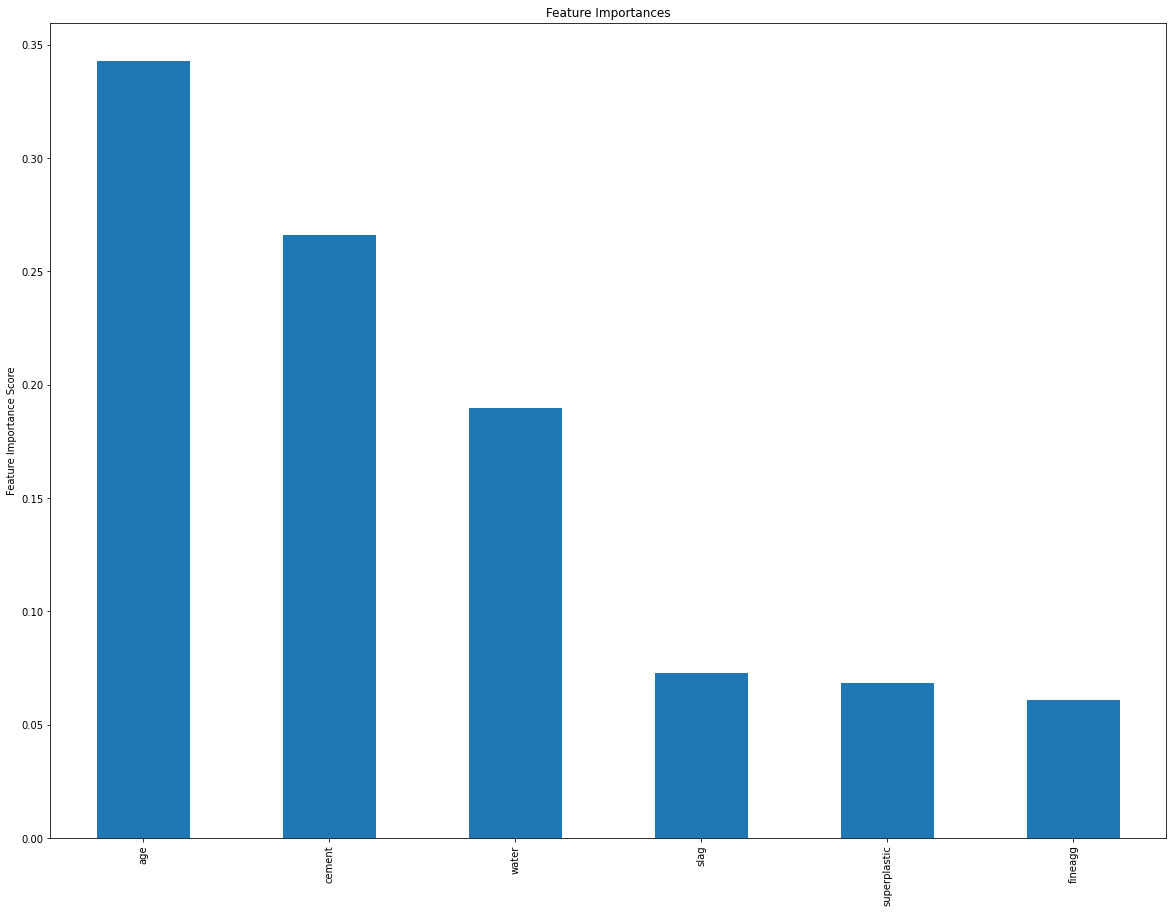

In [ ]:
modelfit(gs3.best_estimator_,X_train, X_valid, X_test)

Slight improvement in performance is observed as can be seen by comparing the MAPE

Text(0.5, 1.0, 'Actuals v Predicted')

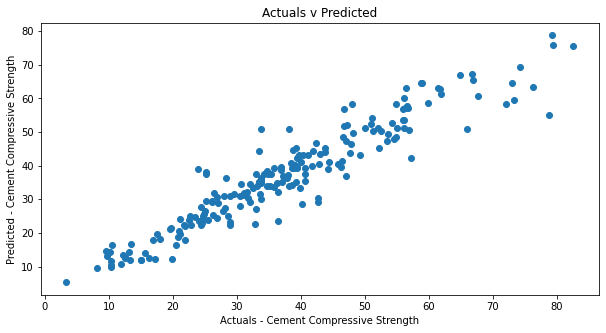

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, gs3.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

#### Tuning subsample and making models with lower **learning rate**

In [ ]:
param_test4 = {'subsample': [0.6,0.85,0.65,0.7,0.75,0.8]}
gridsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_leaf=15,n_estimators=140,
                                                               max_depth=11,random_state=10, min_samples_split=10,
                                                                max_features=3),
                        param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,cv=10)
gs4=gridsearch4.fit(X_train,y_train)
gs4.best_params_, gs4.best_score_

({'subsample': 0.8}, -27.846808343132796)


Model Report
Rsq (Train): 0.981
Rsq (Validation): 0.8973
Rsq (Test): 0.8925


MAPE (Train): 5.895516
MAPE (Valid): 13.335663
MAPE (Test): 11.058310


Correlation Coeff (Test): 0.945122
CV Score : Mean - -27.84681 | Std - 9.040212 | Min - -44.68582 | Max - -15.40852


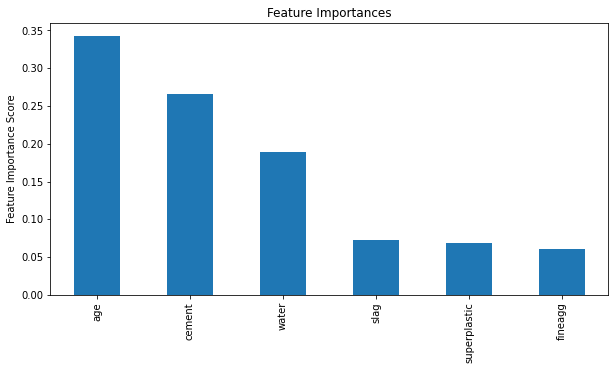

In [ ]:
plt.figure(figsize=(10,5))
modelfit(gs4.best_estimator_, X_train, X_valid, X_test)

#### Try lowering the **learning rate** and increase **the number of trees** simulataneously.


Model Report
Rsq (Train): 0.9795
Rsq (Validation): 0.9015
Rsq (Test): 0.9024


MAPE (Train): 5.866053
MAPE (Valid): 13.410687
MAPE (Test): 11.221368


Correlation Coeff (Test): 0.950143
CV Score : Mean - -28.69112 | Std - 10.2607 | Min - -43.58861 | Max - -16.57936


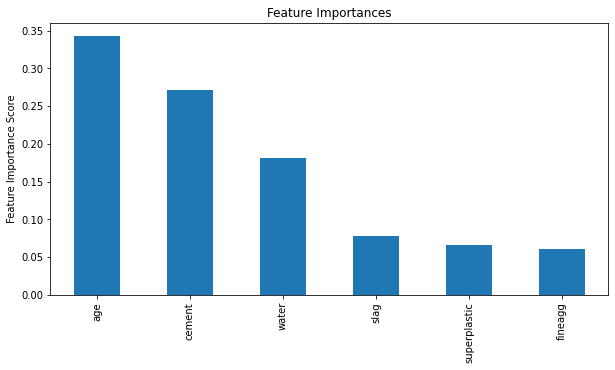

In [ ]:
gbm_tuned= GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=11,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85)
                                     
plt.figure(figsize=(10,5))
modelfit(gbm_tuned, X_train,X_valid, X_test)

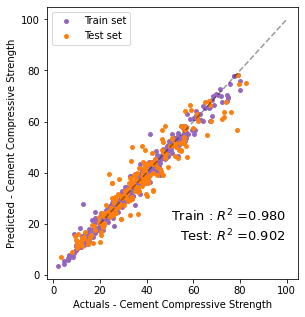

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,5))

ax.scatter(y_train, gbm_tuned.predict(X_train), color='C4', label='Train set', s=15)
ax.scatter(y_test, gbm_tuned.predict(X_test), color='C1', label='Test set', s=15)
ax.set_xlabel("Actuals - Cement Compressive Strength")
ax.set_ylabel("Predicted - Cement Compressive Strength")
ax.legend(loc='upper left')

# y=x dashed line
ax.plot([20,100], [20,100], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.14, f"Train : $R^2$ ={r2_score(y_train, gbm_tuned.predict(X_train)):0.3f}\nTest: $R^2$ ={r2_score(y_test, gbm_tuned.predict(X_test)):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./performance.png")


Best performance achieved with the tuned GBM model. However the model was trained and tuned on the original data. We saw that there is a non-linearship between X and Y.

### Try the boosting model on transformed data

PolynomialFeatures(degree=2).fit_transform(X)

사이킷런의 PolynomialFeatures를 사용해 훈련 데이터를 변환

다항회귀 : 비선형 데이터를, 각 특성의 거듭제곱을 새로운 특성으로 축다하고, 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 기법

훈련세트에 있는 각 특성을 제곱(2차 다항)하여 새로운 특성으로 추가한다


Model Report
Rsq (Train): 0.9795
Rsq (Validation): 0.9015
Rsq (Test): 0.9024


MAPE (Train): 5.866053
MAPE (Valid): 13.410687
MAPE (Test): 11.221368


Correlation Coeff (Test): 0.950143
CV Score : Mean - -28.69112 | Std - 10.2607 | Min - -43.58861 | Max - -16.57936


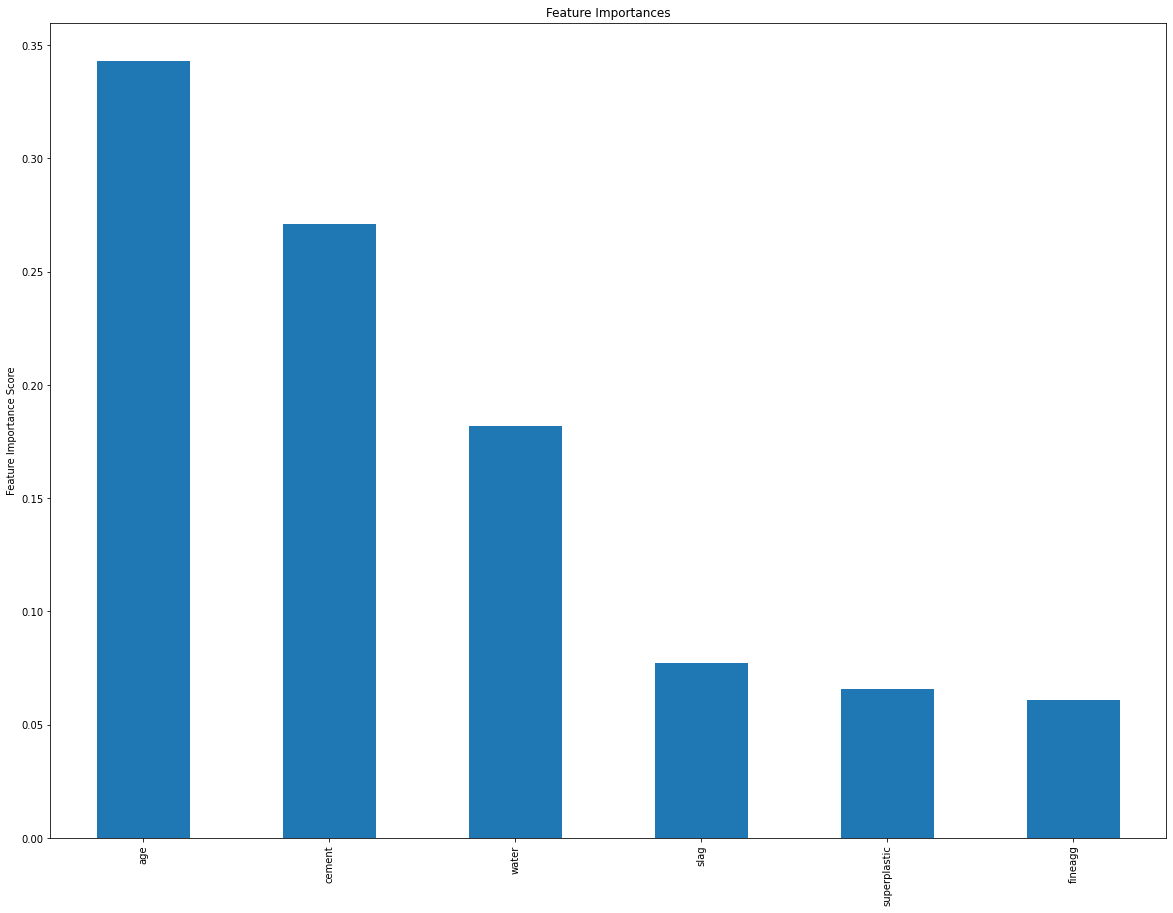

In [ ]:
modelfit(GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,
                                                               max_depth=11,random_state=10,min_samples_split=10,
                                                                max_features=3,subsample=0.85), X_train_tr,X_valid_tr, X_test)

Almost identical results with higher dimensional tranformation of independent variables

## Random Forest

### Start with all predictors

In [51]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns


Model Report
Rsq (Train): 0.9832
Rsq (Validation): 0.8574
Rsq (Test): 0.8611


MAPE (Train): 5.693406
MAPE (Valid): 16.348475
MAPE (Test): 14.102902


Correlation Coeff (Test): 0.928009
CV Score : Mean - -39.02233 | Std - 12.23925 | Min - -63.77606 | Max - -22.42239


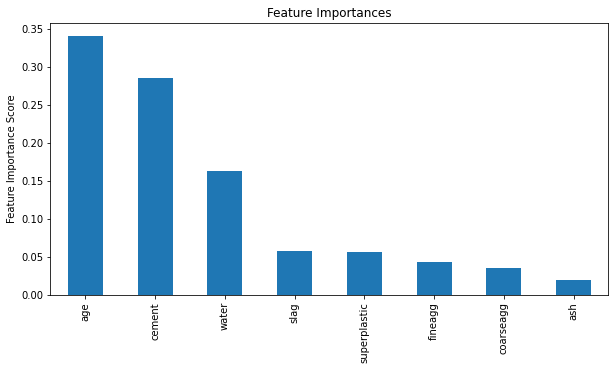

In [52]:
Rf_regressor1= RandomForestRegressor()

plt.figure(figsize=(10,5))
modelfit(Rf_regressor1, X_train, X_valid, X_test)

### Hyperparameter Tuning

#### Parameter tuning starting with **no. of trees** along with Feature Selection

Drop variables that are not significant as can be seen above (ash and coarseagg)

In [53]:
X=df.drop(['ash','coarseagg','strength','cluster'], axis=1).values
y=df.strength.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

predictors=df.drop(['ash','coarseagg','strength','cluster'], axis=1).columns

In [54]:
param_test1 = {'n_estimators':range(20,150,10)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=15,min_samples_leaf=15, max_depth=8,
                                                          max_features='sqrt',random_state=10),
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs1=gsearch1.fit(X_train,y_train)
gs1.best_params_, gs1.best_score_

({'n_estimators': 80}, -86.64839109045909)

#### Fix **n_estimators** at 80. Tune for **max depth** and **min_samples_split**

In [55]:
param_test2 = {'max_depth':range(4,16,2), 'min_samples_split':range(10,100,10)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(min_samples_leaf=15,n_estimators=80,
                                                               max_features='sqrt',random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs2=gsearch2.fit(X_train,y_train)
gs2.best_params_, gs2.best_score_

({'max_depth': 6, 'min_samples_split': 10}, -86.50473097159554)

Fix max_depth at 6 and min_samples_split at 10 and check perforamce


Model Report
Rsq (Train): 0.7637
Rsq (Validation): 0.6936
Rsq (Test): 0.6823


MAPE (Train): 25.993273
MAPE (Valid): 29.556757
MAPE (Test): 24.052865


Correlation Coeff (Test): 0.851291
CV Score : Mean - -86.50473 | Std - 22.02487 | Min - -122.5044 | Max - -58.15378


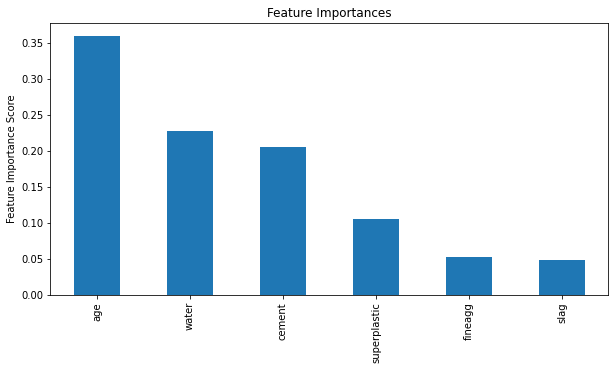

In [56]:
plt.figure(figsize=(10,5))
modelfit(gs2.best_estimator_,X_train, X_valid, X_test)

#### Now lets tune the last tree-parameters, i.e. max_features and for min_samples_leaf

In [57]:
param_test3 = {'max_features':range(3,7,1), 'min_samples_leaf':range(10,100,10)}


gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators=80,
                                                               max_depth=6,random_state=10, min_samples_split=10),
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1, cv=10)
gs3=gsearch3.fit(X_train,y_train)
gs3.best_params_, gs3.best_score_

({'max_features': 5, 'min_samples_leaf': 10}, -64.4331237557486)


Model Report
Rsq (Train): 0.8458
Rsq (Validation): 0.7741
Rsq (Test): 0.7637


MAPE (Train): 18.924226
MAPE (Valid): 22.823102
MAPE (Test): 19.478498


Correlation Coeff (Test): 0.875969
CV Score : Mean - -64.43312 | Std - 19.99407 | Min - -105.676 | Max - -39.11362


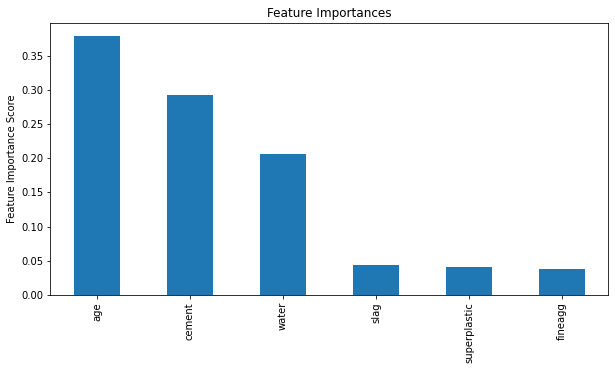

In [58]:
plt.figure(figsize=(10,5))
modelfit(gs3.best_estimator_, X_train,X_valid, X_test)

The best results were achieved without any tuning and feature selection with the random forest regressor.

 ### Let's put the removed variables back to compare performace


Model Report
Rsq (Train): 0.842
Rsq (Validation): 0.7736
Rsq (Test): 0.7675


MAPE (Train): 20.248176
MAPE (Valid): 24.614367
MAPE (Test): 20.134855


Correlation Coeff (Test): 0.883991
CV Score : Mean - -66.64337 | Std - 17.64401 | Min - -93.41486 | Max - -42.27221


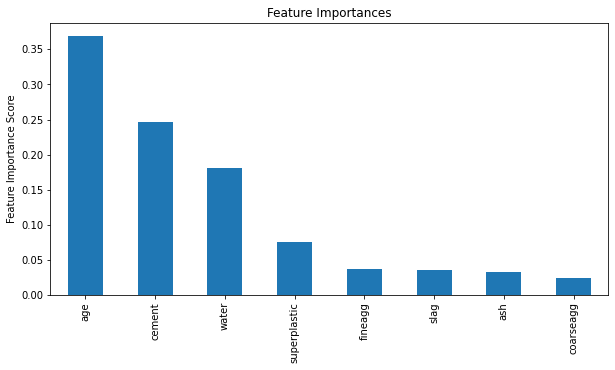

In [59]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength','cluster'] ,axis=1).columns
Rf_regressor= RandomForestRegressor(n_estimators=80,max_depth=8,random_state=10, min_samples_split=10, max_features=4,
                                   min_samples_leaf=10)
plt.figure(figsize=(10,5))
#Choose all predictors
modelfit(Rf_regressor, X_train, X_valid, X_test)

The random forest regressor without any feature selection and any tuning gave the best results amongst all random forest models build. 

### The tuned boosting model though has given the best results.

Text(0.5, 1.0, 'Actuals v Predicted')

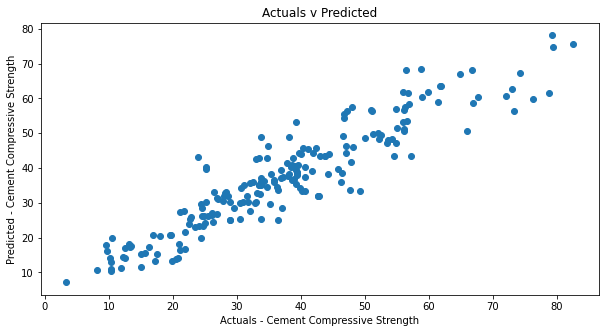

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, Rf_regressor1.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

## XGBoost

In [39]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

X=df.iloc[:,0:8].values
y=df.strength.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)

predictors = ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg','fineagg', 'age']   # df.drop(['strength','cluster'], axis=1).columns
Xgb_regressor= XGBRegressor()

In order to decide on boosting parameters, we need to set some initial values of other parameters.

[14:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

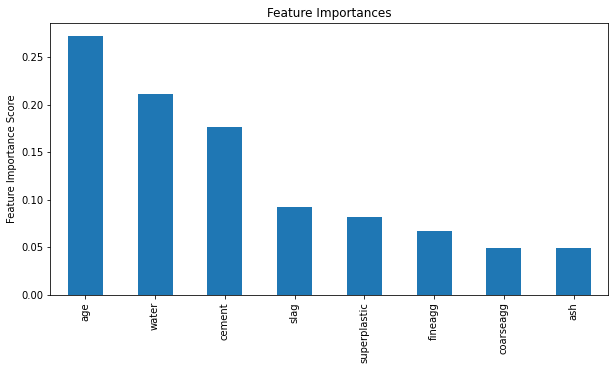

In [40]:
xgb1 = XGBRegressor(booster='gbtree',
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

plt.figure(figsize=(10,5))
modelfit(xgb1, X_train, X_valid, X_test, predictors)

### Hyperparameter Tuning

#### Tune max_depth and min_child_weight

In [41]:
param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 5, 'min_child_weight': 2}, -27.521435237540818)

[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

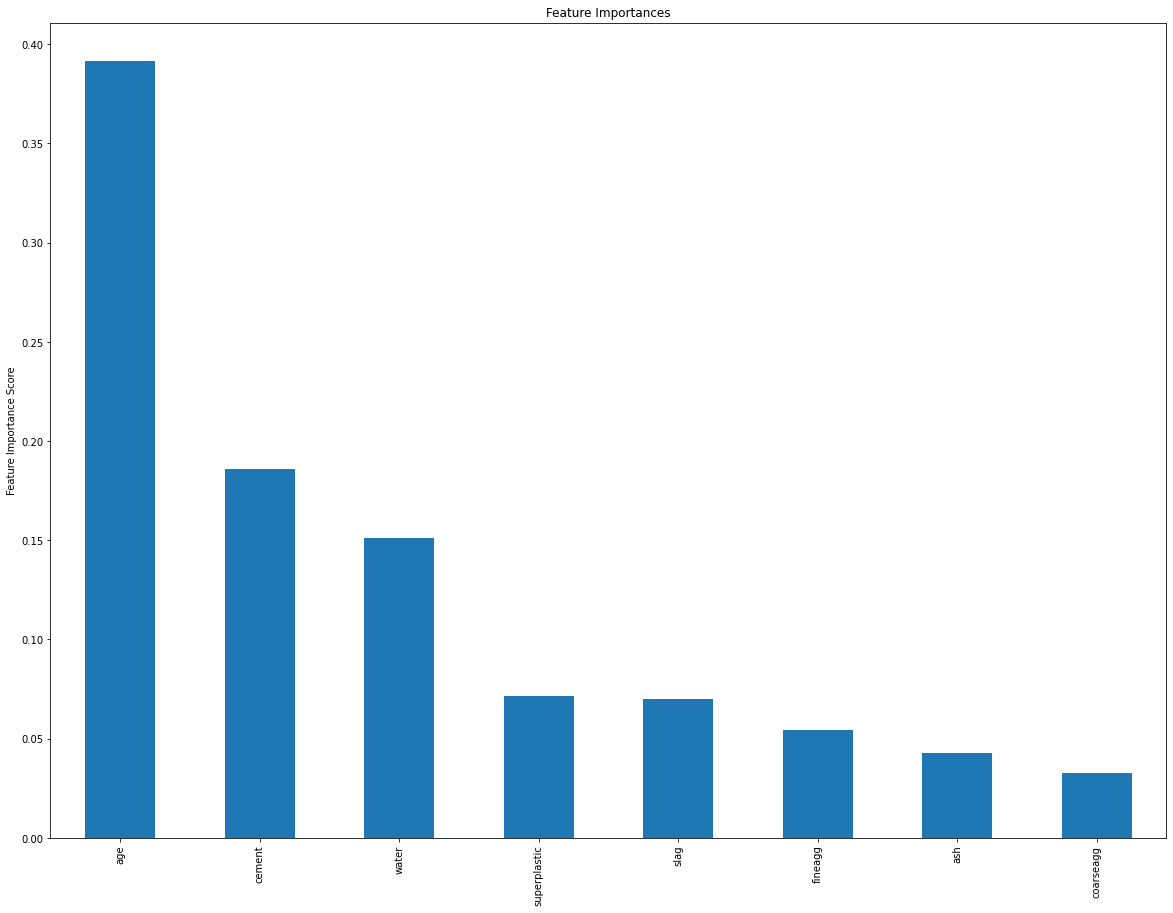

In [42]:
modelfit(gsearch1.best_estimator_, X_train,X_valid,X_test, predictors)

#### Tune gamma

In [43]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch1.best_score_

[14:51:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.2}, -27.521435237540818)

#### Tune subsample and colsample_bytree

In [44]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, gamma=0, min_child_weight=1,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch1.best_score_

[14:52:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.8, 'subsample': 0.8}, -27.521435237540818)

#### Tuning Regularization Parameters

In [45]:
param_test4 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch1.best_score_

[14:52:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 0.01}, -27.521435237540818)

[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

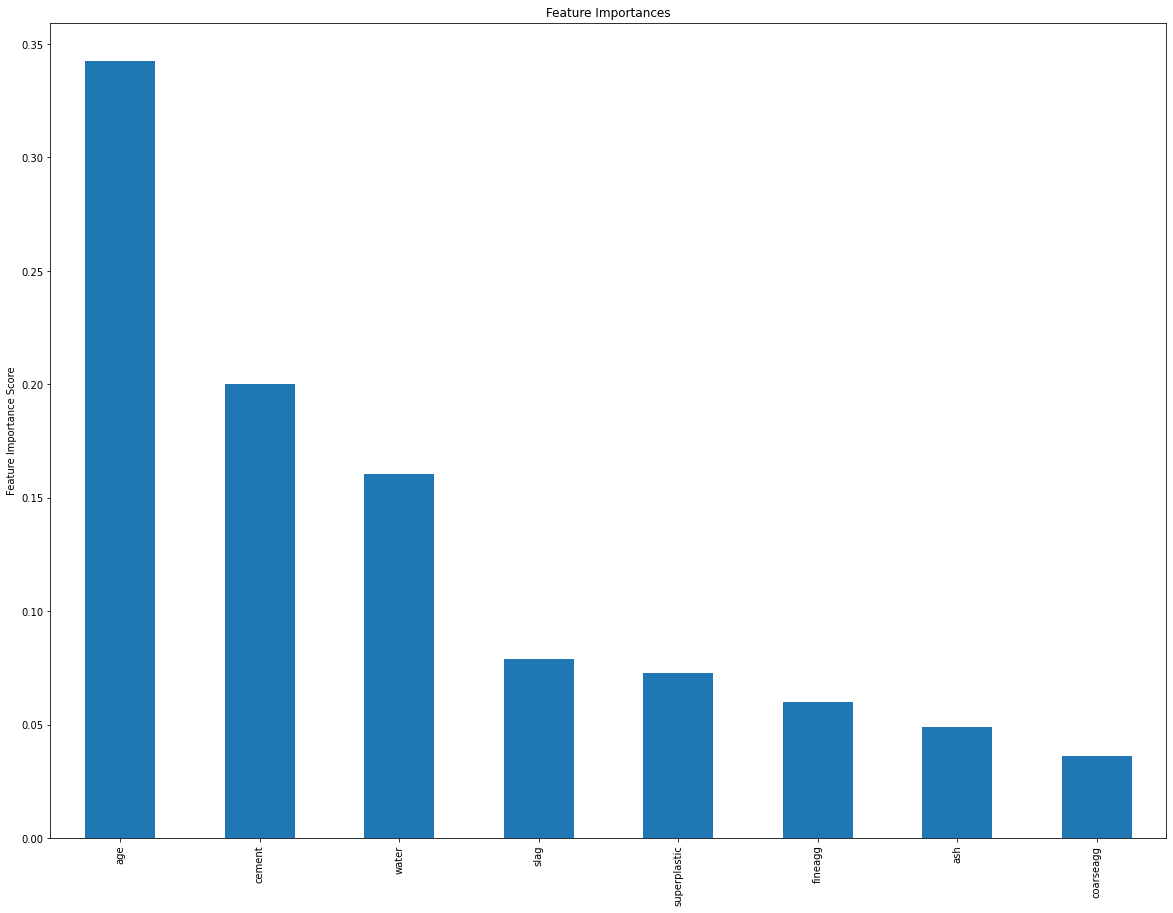

In [46]:
modelfit(gsearch4.best_estimator_, X_train,X_valid,X_test, predictors)

#### Tune Regularization parameter more smaller

In [47]:
param_test5 = {
 'reg_alpha':[0.07,0.08,0.09,0.1,0.11,0.12]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=1000,
 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
 nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch1.best_score_

[14:52:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 0.01}, -27.521435237540818)

[14:52:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

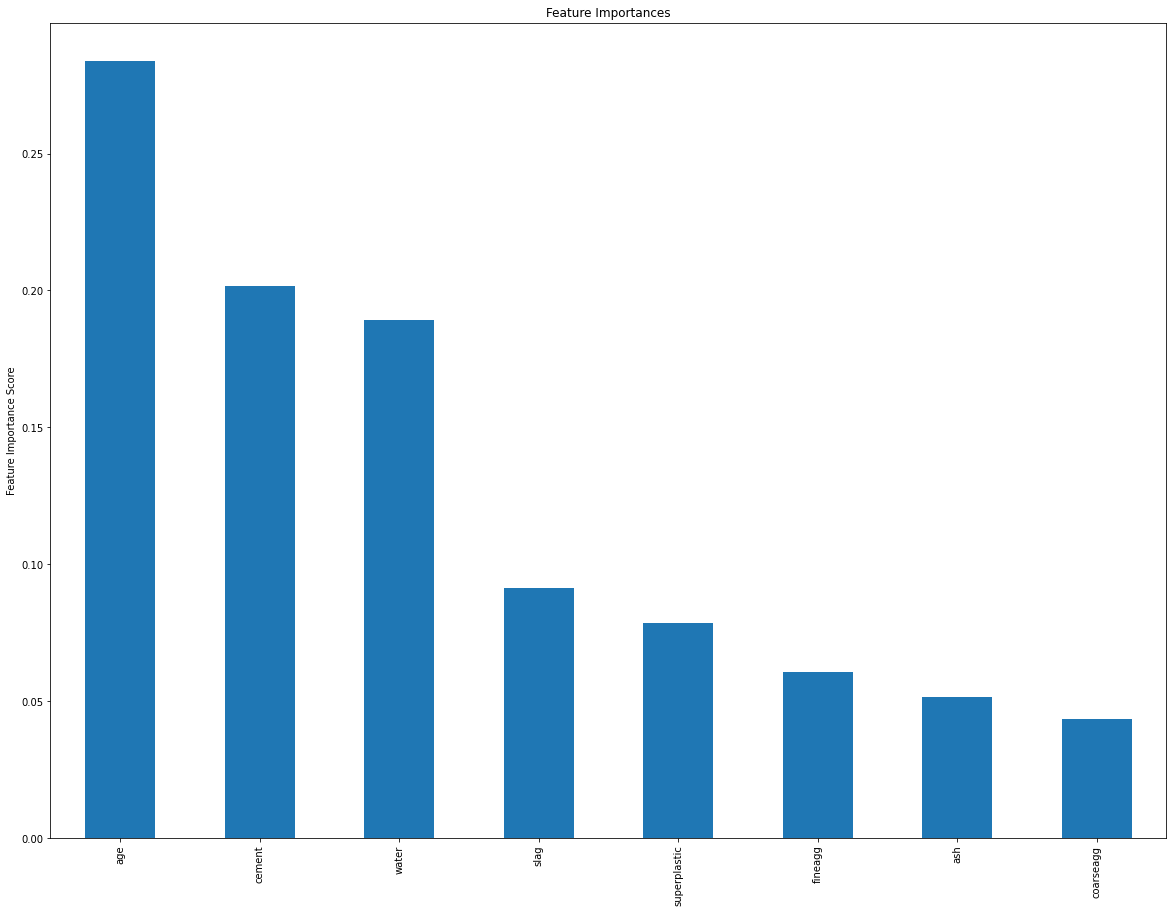

In [48]:
modelfit(gsearch5.best_estimator_, X_train,X_valid,X_test, predictors)


Since the first XGB model produced the least MAPE, we could try Reducing Learning Rate for the first model and double the no. of estimators

#### Try Reducing Learning Rate for the first model and double the no. of estimators

In [49]:
XGB=XGBRegressor( booster='gbtree', learning_rate =0.05, n_estimators=2000,
                 max_depth=4, subsample=0.8, colsample_bytree=0.8,min_child_weight=1,gamma=0,
                 nthread=4, scale_pos_weight=1,reg_alpha=0.1 ,seed=27)

[14:52:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:53:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

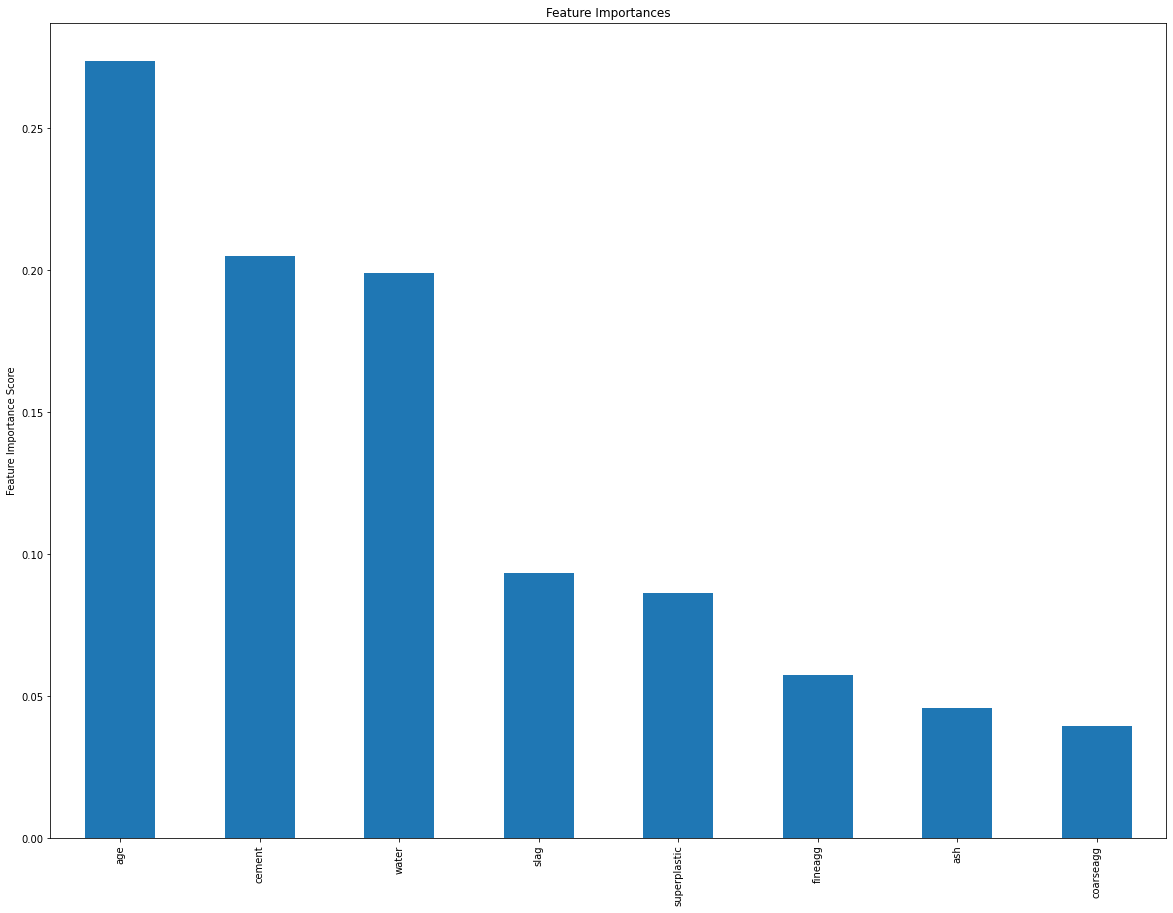

In [50]:
modelfit(XGB, X_train,X_valid, X_test, predictors)

The best results are achieved through the fully tuned gbm model and the XGB model above. XGB gives slightly better results but the computation time is a little more. Any of the two models can be used in production

## Support Vector Machine

In [ ]:
X=df.drop(['strength','cluster'], axis=1).values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)
X_train,X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=2, test_size=0.5)
predictors=df.drop(['strength', 'cluster'], axis=1).columns

### Hyperparameter Tuning

In [ ]:
param_grid = {'kernel': ['rbf','sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4],'C': [0.1, 10, 25]}

gsearch1 = GridSearchCV(estimator = SVR(),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
gs1=gsearch1.fit(X_train,y_train)

In [ ]:
print(gs1.best_params_, gs1.best_score_)
print("Correlation_Validation:", np.corrcoef(y_valid,gs1.predict(X_valid))[0,1])
print("Correlation_Test:", np.corrcoef(y_test,gs1.predict(X_test))[0,1])

Rsq_valid=r2_score(y_valid,gs1.predict(X_valid))
Rsq_test=r2_score(y_test,gs1.predict(X_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test_RidGS:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,gs1.predict(X_test))
print('MAPE_RidGS:%.2f' %MAPE_Test)

{'C': 25, 'gamma': 0.0001, 'kernel': 'rbf'} -71.94229055417847
Correlation_Validation: 0.8903941485675019
Correlation_Test: 0.8508463176673294
Rsq_Adj_valid:0.62
Rsq_Adj_test_RidGS:0.50
MAPE_RidGS:20.00


In [ ]:
#Print model report:
print("\nModel Report")
print("Rsq (Train): %.4g" % r2_score(y_train, gs1.predict(X_train)))
print("Rsq (Validation): %.4g" % r2_score(y_valid, gs1.predict(X_valid)))
print("Rsq (Test): %.4g" % r2_score(y_test, gs1.predict(X_test)))


Model Report
Rsq (Train): 0.9237
Rsq (Validation): 0.7912
Rsq (Test): 0.7222


In [ ]:
param_grid = {'kernel': ['rbf'], 'gamma': [0.0001,0.000025,0.0000125,0.0000125/2,0.0000125/4],
              'C': [750,1000,1150,1175,1200,1225]}

gsearch2 = GridSearchCV(estimator = SVR(),param_grid = param_grid, scoring='neg_mean_squared_error',n_jobs=-1, cv=5)
gs2=gsearch2.fit(X_train,y_train)

In [ ]:
print(gs2.best_params_, gs2.best_score_)
print("Correlation_Validation:", np.corrcoef(y_valid,gs2.predict(X_valid))[0,1])
print("Correlation_Test:", np.corrcoef(y_test,gs2.predict(X_test))[0,1])

Rsq_valid=r2_score(y_valid,gs2.predict(X_valid))
Rsq_test=r2_score(y_test,gs2.predict(X_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,gs2.predict(X_test))
print('MAPE_SVR:%.2f' %MAPE_Test)

{'C': 750, 'gamma': 1.25e-05, 'kernel': 'rbf'} -47.424627694103826
Correlation_Validation: 0.9293979951844121
Correlation_Test: 0.9034500777401115
Rsq_Adj_valid:0.73
Rsq_Adj_test:0.63
MAPE_SVR:14.96


In [ ]:
#Print model report:
print("\nModel Report")
print("Rsq (Train): %.4g" % r2_score(y_train, gs2.predict(X_train)))
print("Rsq (Validation): %.4g" % r2_score(y_valid, gs2.predict(X_valid)))
print("Rsq (Test): %.4g" % r2_score(y_test, gs2.predict(X_test)))


Model Report
Rsq (Train): 0.9358
Rsq (Validation): 0.8575
Rsq (Test): 0.8019


With Multiple iterations of the rbf kernel grid search, the best model achieved is with the above hyperparameters

## Stacking

In [37]:
pip install vecstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19879 sha256=c9196def834fb6d6da6b37ea46162606615bcb689e7bccd759a9b4d9be157712
  Stored in directory: /root/.cache/pip/wheels/17/89/0b/21d5484cbf713c95b641ec1bdc40dd7ae798cbdea2337e3535
Successfully built vecstack


In [69]:
from vecstack import stacking

models = [
    GradientBoostingRegressor(learning_rate=0.025,min_samples_leaf=15,n_estimators=440,max_depth=13,random_state=10,
                              min_samples_split=10,max_features=3,subsample=0.85),
        
    RandomForestRegressor(),
        
    XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
                 subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27),
    
    gsearch2.best_estimator_ , #Support Vector Regressor
    
    Las_gs.best_estimator_ #Lasso model tried earlier
            
]

In [70]:
X=df.iloc[:,0:8].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[14:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [71]:
#The beta model is below

model = Ridge()

model = model.fit(S_train, y_train)


Rsq_test=r2_score(y_test,model.predict(S_test))


Rsq_Adj_valid= 1- (((1-Rsq_valid**2)*(n_valid-1))/(n_valid-k-1))
print('Rsq_Adj_valid:%.2f'%Rsq_Adj_valid)

#Rsq_Adj= 1- [(1-Rsq^2)*(n-1)/(n-k-1)]
Rsq_Adj_test= 1- (((1-Rsq_test**2)*(n_test-1))/(n_test-k-1))
print('Rsq_Adj_test:%.2f'%Rsq_Adj_test)


MAPE_Test=mean_absolute_percentage_error(y_test,model.predict(S_test))
print('MAPE_stackedModels:%.2f' %MAPE_Test)

Rsq_Adj_valid:0.37
Rsq_Adj_test:0.85
MAPE_stackedModels:8.85


Text(0.5, 1.0, 'Actuals v Predicted')

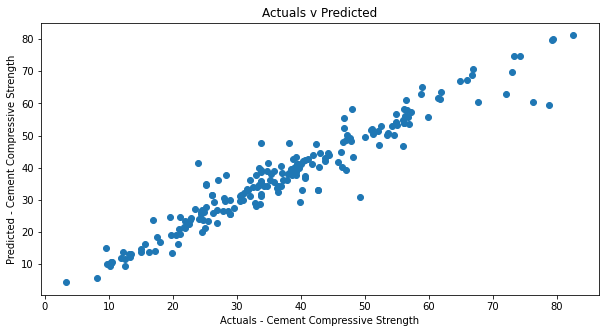

In [72]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, model.predict(S_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

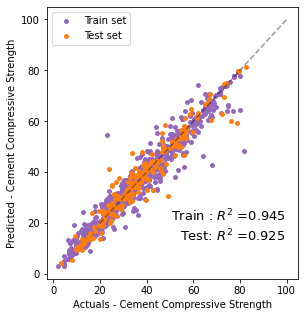

In [73]:
fig, ax = plt.subplots(figsize=(4.5,5))

ax.scatter(y_train, model.predict(S_train), color='C4', label='Train set', s=15)
ax.scatter(y_test, model.predict(S_test), color='C1', label='Test set', s=15)

ax.set_xlabel("Actuals - Cement Compressive Strength")
ax.set_ylabel("Predicted - Cement Compressive Strength")
ax.legend(loc='upper left')

# y=x dashed line
ax.plot([20,100], [20,100], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.14, f"Train : $R^2$ ={r2_score(y_train, model.predict(S_train)):0.3f}\nTest: $R^2$ ={r2_score(y_test, model.predict(S_test)):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

plt.savefig(f"./performance.png")

## stacking with New Data

In [74]:
dome_df = pd.read_csv("/content/drive/MyDrive/MSML/Concrete/DATASET/domestic.csv")

X_new = dome_df.drop(columns='strength')
y_new = dome_df['strength']

X_df = pd.DataFrame(df.iloc[:,0:8].values, columns= ['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'age'])
y_df = pd.Series(df.strength.values)

X = df.iloc[:,0:8].values
y = df.strength.values
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

In [75]:
S_train, S_new = stacking(models,                   
                           X, y, X_new,   # X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[14:58:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

The beta model is below

In [76]:
model = Ridge()
model = model.fit(S_train, y)

In [77]:
#Print model report:
print("\nModel Report")
print("Rsq (Train): %.4g" % r2_score(y, model.predict(S_train)))
print("Rsq (Test): %.4g" % r2_score(y_new, model.predict(S_new)))


Model Report
Rsq (Train): 0.9504
Rsq (Test): -36.65


Text(0.95, 0.14, 'Train : $R^2$ =0.950\nTest: $R^2$ =-36.654')

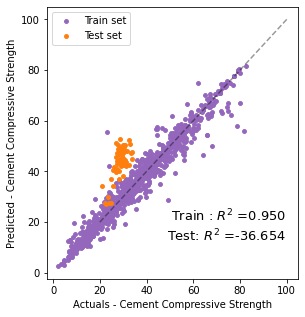

In [78]:
fig, ax = plt.subplots(figsize=(4.5,5))

ax.scatter(y, model.predict(S_train), color='C4', label='Train set', s=15)
ax.scatter(y_new, model.predict(S_new), color='C1', label='Test set', s=15)

ax.set_xlabel("Actuals - Cement Compressive Strength")
ax.set_ylabel("Predicted - Cement Compressive Strength")
ax.legend(loc='upper left')

# y=x dashed line
ax.plot([20,100], [20,100], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.14, f"Train : $R^2$ ={r2_score(y,model.predict(S_train)):0.3f}\nTest: $R^2$ ={r2_score(y_new, model.predict(S_new)):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")


### Trial

In [79]:
input = np.array(df.iloc[:,0:8].columns)
input

array(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'], dtype=object)

In [80]:
input[0] = 550
input[1] = 0
input[2] = 0
input[3] = 148
input[4] = 12.1
input[5] = 1056
input[6] = 700
input[7] = 28   # setting
input

array([550, 0, 0, 148, 12.1, 1056, 700, 28], dtype=object)

In [81]:
input = input.reshape(1,-1)
S_train, S_input = stacking(models,                   
                           X, y, input,   # X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[14:59:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [82]:
model.predict(S_input)

array([68.58975592])

improve compressive strength

In [83]:
input = np.array(df.iloc[:,0:8].columns)

In [84]:
input[0] = 315.0
input[1] = 137.0
input[2] = 0
input[3] = 145.0
input[4] = 5.9
input[5] = 1130
input[6] = 745
input[7] = 28   # setting
input

array([315.0, 137.0, 0, 145.0, 5.9, 1130, 745, 28], dtype=object)

In [85]:
input = input.reshape(1,-1)
S_train, S_input = stacking(models,                   
                           X, y, input,   # X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[14:59:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [86]:
model.predict(S_input)

array([76.44449973])

In [ ]:
input = np.array(df.iloc[:,0:8].columns)
input[0] = 451
input[1] = 0
input[2] = 0
input[3] = 165
input[4] = 11.3
input[5] = 1030
input[6] = 745
input[7] = 28   # setting
input

array([451, 0, 0, 165, 11.3, 1030, 745, 28], dtype=object)

In [ ]:
input = input.reshape(1,-1)
S_train, S_input = stacking(models,                   
                           X, y, input,   # X_train, y_train, X_test,   
                           regression=True,      
                           mode='oof_pred_bag',       
                           needs_proba=False,         
                           save_dir=None,            
                           metric='neg_mean_squared_error',     
                           n_folds=10,                 
                           shuffle=True,            
                           random_state=0,         
                           )

[04:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:00:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
model.predict(S_input)

array([73.23126581])